# Creating a Model to Predict whether an Animated Film will Nominated.

## Feature
In this model the only feature I will consider is the month of a movie release. 

In [21]:
# import packages for handling the data and plotting 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imdb import Cinemagoer

from helper_functions import a, get_month, drop_test, timeseries_split

sns.set_style("whitegrid")

In [22]:
# load in data set
movie_data = pd.read_pickle('../Data/df_of_imdb_data.pkl')

# look at first couple of entries 
movie_data.head()

,imdb_id,titles,year,original_air_date,countries,language,genres,certificates,rating,votes,color_info,runtimes,box_office,producers,directors,production_company,distributors,metascore,is_nominee
0,0388130,Initial D: Third Stage,2001,13 Jan 2001 (Japan),[Japan],"[en, ja, cmn]","[Animation, Action, Romance, Sport]","[Australia:PG, Japan:G, United States:TV-PG]",7.6,1390,[Color],[100],[],[2246748],"[1245306, 1564830]","[0179653, 0021660, 0099762, 0113955, 0036168]","[0179653, 0053157, 0039940, 0921883]","{'data': {}, 'titlesRefs': {}, 'namesRefs': {}}",0
1,0273772,Don't Make Trouble!,2001,17 Jan 2001 (France),[France],"[fr, ar]","[Animation, Drama, Comedy]",[France:Tous publics],6.6,49,[Color],[70],[],"[1007620, 0099748, 0501590, 0851724]","[0002174, 0071117, 0099379, 0181117, 0216816, ...","[0072738, 0069857]",[0038517],"{'data': {}, 'titlesRefs': {}, 'namesRefs': {}}",0
2,0243017,Waking Life,2001,07 Mar 2002 (Australia),[United States],[en],"[Animation, Drama, Fantasy]","[Argentina:13, Australia:M, Brazil:Livre, Cana...",7.7,63692,[Color],[99],"{'Opening Weekend United States': '$88,977, 21...","[0438210, 0657921, 0782270, 0806189, 0808819, ...",[0000500],"[0028932, 0046530, 0042682, 0054189, 0123642, ...","[0000756, 0028932, 0007180, 0125154, 0067533, ...","{'data': {'metascore': '83', 'metacritic url':...",0
3,0291559,Wave Twisters,2001,[],[United States],[en],"[Animation, Adventure, Musical, Sci-Fi]",[United States:Unrated],7.4,551,[Color],[46],[],[1029039],"[1000898, 1037263]",[0060259],[],"{'data': {}, 'titlesRefs': {}, 'namesRefs': {}}",0
4,0277909,Mutant Aliens,2001,09 Jan 2002 (France),[United States],[en],"[Animation, Comedy, Sci-Fi]","[France:Tous publics, Germany:16, South Korea:...",6.6,1204,[Color],[81],"{'Budget': '$200,000 (estimated)'}","[0390350, 0687739]",[0687739],[0077590],"[0068070, 0112126, 0084806]","{'data': {'metascore': '39', 'metacritic url':...",0


We are doing a time series type split where the training set is movies from 2001-2017 and the test set is movies from 2018-2019. So a first step would be to make sure that every movie has a year

In [23]:
# checking for empty years
movie_data['year'].apply(lambda y: False if len(str(y)) < 4 else True).sum()

3900

In [24]:
# one movie is missing a year we can look it up and then replace it with its year
# if it is relevant

# replace empty year as a nan 
movie_data_copy = movie_data['year'].apply(lambda y: np.nan if len(str(y)) < 4 else y)

# find index of nan year 
np.where(pd.isnull(movie_data_copy))

(array([3107]),)

In [25]:
movie_data.iloc[3107]

imdb_id                                                      10172802
titles                                               Outlander - IMDb
year                                                               []
original_air_date                             04 Jul 2019 (Australia)
countries                                             [United States]
language                                                         [en]
genres                                                    [Animation]
certificates                                            [Australia:M]
rating                                                             []
votes                                                              []
color_info                                                    [Color]
runtimes                                                         [68]
box_office                             {'Budget': 'AUD5 (estimated)'}
producers                                                  [10616103]
directors           

In [26]:
# manually add year 2019 for now 
movie_data['year'].values[3107] = 2019
movie_data.iloc[3107]

imdb_id                                                      10172802
titles                                               Outlander - IMDb
year                                                             2019
original_air_date                             04 Jul 2019 (Australia)
countries                                             [United States]
language                                                         [en]
genres                                                    [Animation]
certificates                                            [Australia:M]
rating                                                             []
votes                                                              []
color_info                                                    [Color]
runtimes                                                         [68]
box_office                             {'Budget': 'AUD5 (estimated)'}
producers                                                  [10616103]
directors           

In [27]:
# Test Train Split 

# First drop movies missing an original air date
#movie_data['original_air_date'] = movie_data['original_air_date'].apply(lambda y: np.nan if len(y) == 0 else y)
#movie_data = movie_data.dropna()

movie_data_train = movie_data[movie_data['year'] <= 2017].copy()
movie_data_test = movie_data[(movie_data['year'] >= 2018)
                            & (movie_data['year'] <= 2019)].copy()


In [28]:
movie_data_train['original_air_date'].head()

0        13 Jan 2001 (Japan)
1       17 Jan 2001 (France)
2    07 Mar 2002 (Australia)
3                         []
4       09 Jan 2002 (France)
Name: original_air_date, dtype: object

In [29]:
# all of the possible date lengths 
movie_data_train['original_air_date'].apply(a).apply(lambda x: len(x)).explode().value_counts()

12    1927
0      493
5      128
9      107
Name: original_air_date, dtype: int64

In [30]:
def get_month(date_string):
    POSSIBLE_DATE_FORMATS = ['%d %b %Y ', '%b %Y '] 
    for date_format in POSSIBLE_DATE_FORMATS:
        try:
            return datetime.strptime(date_string, date_format).month 
        except ValueError:
            pass # if incorrect format, keep trying other formats
    return 0

We now have a dataframe that contains the dates and the nominees, we want to create a dataframe that only captures the months and also encodes the months to variables from 1-12 

In [31]:
from datetime import datetime
movie_data_train['month_num'] = movie_data_train['original_air_date'].apply(a).apply(get_month)


In [32]:
X_train = movie_data_train['month_num']
y_train = movie_data_train['is_nominee']

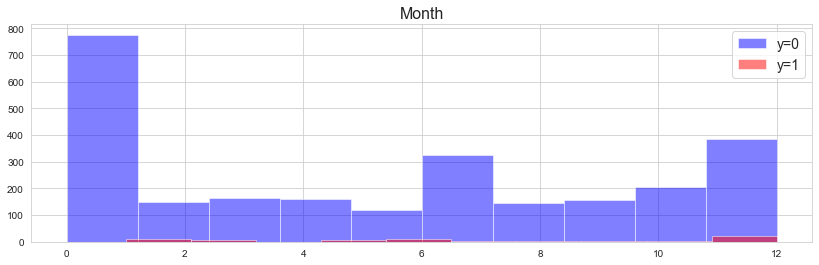

In [33]:
plt.figure(figsize=(14,4))
plt.hist(X_train[y_train==0], color='b', alpha=.5, label="y=0")
plt.hist(X_train[y_train==1], color='r', alpha=.5, label="y=1")
plt.legend(fontsize=14)
plt.title('Month',fontsize=16)
plt.show()

Looking the distribution of original air date months it does not look like this is a feature that classifies being nominated or not. Nevertheless I will build some models anyways

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score

In [38]:
log_reg_tprs = np.zeros((5, len(X_train)))
log_reg_fprs = np.zeros((5, len(X_train)))
log_reg_precs = np.zeros((5, len(X_train)))

i = 0
for train_index, test_index in timeseries_split(movie_data_train,5):
    X_train = movie_data_train[['year','month_num']]
    y_train = movie_data_train['is_nominee']
    X_tt = X_train.iloc[train_index]
    X_ho = X_train.iloc[test_index]
    y_tt = y_train.iloc[train_index]
    y_ho = y_train.iloc[test_index]
    j = 0
    for c in X_train.columns:
        log_reg = LogisticRegression()
        
        log_reg.fit(X_tt[c].values.reshape(-1,1), y_tt.values)
        
        pred = log_reg.predict(X_ho[c].values.reshape(-1,1))
        
        conf_mat = confusion_matrix(y_ho.values, pred)
        
        log_reg_precs[i,j] = precision_score(y_ho.values, pred)
        log_reg_tprs[i,j] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
        log_reg_fprs[i,j] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
        j = j + 1
    i = i + 1

/Users/wmreese/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wmreese/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wmreese/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wmreese/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_cl

It seems like the logistic regression model is not predicting anything other than 0's